In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.12.0


In [ ]:
# All general imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer 

import keras
!pip install keras_preprocessing
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Reshape, Conv2D, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Bidirectional, GlobalAveragePooling1D, GRU, GlobalMaxPooling1D, concatenate
from keras.optimizers import Adam
from keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Activation, Add

from keras.models import Model, Sequential
from keras.layers.core import SpatialDropout1D

from keras.layers import Layer, Dense, Input, Embedding, Dropout, Activation, Conv2D, MaxPooling2D, AveragePooling2D, Softmax
from keras import initializers, regularizers, constraints, optimizers, layers
from keras import backend as K

from keras.callbacks import EarlyStopping

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
import io, os, gc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

#tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


In [ ]:
# Loading drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Setting the working directory 
!ls
%cd drive/MyDrive/Project
!pwd

drive  sample_data
/content/drive/MyDrive/Project
/content/drive/MyDrive/Project


In [ ]:
#################### Importing ByteDance Dataset ####################

le = LabelEncoder()
le2 = LabelEncoder()

# Train set
train_df = pd.read_csv('data/train_bd_with_labels_2nd.csv')
print(train_df.columns)
train_df['bd_label'] = le.fit_transform(train_df['bd_label']) # agreed = 0, disagreed = 1
train_df['single_new_emo'] = le2.fit_transform(train_df['single_new_emo']) # emotions agree = 0, disagree = 1
train_df.head()

# Test set
test_df = pd.read_csv('data/test_bd_with_labels.csv')
print(test_df.columns)
test_df['bd_label'] = le.transform(test_df['bd_label'])
test_df['single_new_emo'] = le2.transform(test_df['single_new_emo'])
test_df.head()

Index(['id', 'title1_en', 'title2_en', 'bd_label', 'quora_label',
       'Premise_Emotion_Label', 'Hypothesis_Emotion_Label', 'com_femotion',
       'femotion', 'NV_Orc', 'EM_Orc', 'weights', 'single_new_emo',
       'premise_emo', 'hypothesis_emo', 'novelty_label'],
      dtype='object')
Index(['id', 'title1_en', 'title2_en', 'bd_label', 'quora_label',
       'Premise_Emotion_Label', 'Hypothesis_Emotion_Label', 'com_femotion',
       'femotion', 'NV_Orc', 'EM_Orc', 'weights', 'test_wts', 'single_new_emo',
       'premise_emo', 'hypothesis_emo', 'novelty_label'],
      dtype='object')


,id,title1_en,title2_en,bd_label,quora_label,Premise_Emotion_Label,Hypothesis_Emotion_Label,com_femotion,femotion,NV_Orc,EM_Orc,weights,test_wts,single_new_emo,premise_emo,hypothesis_emo,novelty_label
0,321198,wanda collapses: china 's richest man wang jia...,news: the detention of wang jianlin and his fa...,0,1,1,0,1,0,1,1,0.544454,0.066667,0,1,1,1
1,321201,wanda collapses: china 's richest man wang jia...,wang jian 's family is detained,0,1,1,0,1,0,1,1,0.544454,0.066667,0,1,1,1
2,321200,wanda collapses: china 's richest man wang jia...,Exclusive news: Wang Jian-lin is detained in a...,0,1,1,0,1,0,1,1,0.544454,0.066667,0,1,1,1
3,321202,wanda collapses: china 's richest man wang jia...,prc: wang jianlin and his family are detained ...,0,1,1,0,1,0,1,1,0.544454,0.066667,0,1,1,1
4,321205,"The land price 130 thousand, now only needs 33...","$160,000 on the floor. Now it's only $100,000....",0,1,0,0,1,1,1,1,0.544454,0.066667,0,1,1,1


In [ ]:
train_lst_1 = train_df['title1_en'].tolist()
train_lst_2 = train_df['title2_en'].tolist()
uq_tr_1 = list(set(train_lst_1))
uq_tr_2 = list(set(train_lst_2))
train_merged = uq_tr_1 + uq_tr_2
print('Train length is', len(train_merged))

test_lst_1 = test_df['title1_en'].tolist()
test_lst_2 = test_df['title2_en'].tolist()
uq_ts_1 = list(set(test_lst_1))
uq_ts_2 = list(set(test_lst_2))
test_merged = uq_ts_1 + uq_ts_2
print('Test length is', len(test_merged))

total_dataset = train_merged + test_merged
print('Total dataset length is', len(total_dataset))

Train length is 67950
Test length is 25300
Total dataset length is 93250


In [ ]:
train_max_1 = max([len(s) for s in train_lst_1])
train_max_2 = max([len(s) for s in train_lst_2])
train_avg_1 = int(np.average([len(s) for s in train_lst_1]))
train_avg_2 = int(np.average([len(s) for s in train_lst_2]))
train_min_1 = min([len(s) for s in train_lst_1])
train_min_2 = min([len(s) for s in train_lst_2])
print("Train set: ")
print('title1_en -> Max: ', train_max_1, 'Avg: ', train_avg_1, 'Min: ', train_min_1)
print('title2_en -> Max: ', train_max_2, 'Avg: ', train_avg_2, 'Min: ', train_min_2)
test_max_1 = max([len(s) for s in test_lst_1])
test_max_2 = max([len(s) for s in test_lst_2])
test_avg_1 = int(np.average([len(s) for s in test_lst_1]))
test_avg_2 = int(np.average([len(s) for s in test_lst_2]))
test_min_1 = min([len(s) for s in test_lst_1])
test_min_2 = min([len(s) for s in test_lst_2])
print("\nTest set: ")
print('title1_en -> Max: ', test_max_1, 'Avg: ', test_avg_1, 'Min: ', test_min_1)
print('title2_en -> Max: ', test_max_2, 'Avg: ', test_avg_2, 'Min: ', test_min_2)

MAX_LENGTH = 100

Train set: 
title1_en -> Max:  1577 Avg:  93 Min:  6
title2_en -> Max:  4002 Avg:  94 Min:  1

Test set: 
title1_en -> Max:  1050 Avg:  94 Min:  6
title2_en -> Max:  1050 Avg:  95 Min:  1


In [ ]:
import string
!pip install nltk
import nltk
from nltk.tokenize import  word_tokenize

contr_dict = {"i\'m" : "i am",
            "won\'t" : "will not",
            "it\'s" : "it is",
            " \'" : " ",
            "\' " : " ",
            "\'s" : "",
            " \'s" : "",
            " s " : " ",
            "\'ll" : "will",
            "\'ve" : "have",
            "n\'t" : "not",
            "\'re" : "are",
            "\'d" : "would",
            "y'all" : "all of you"}

known_typos = dict()

def encode_char(text):
    text = text.replace(u"\u201d",'"') # replace unicode quotation
    text = text.replace(u"\u201c",'"')
    text = text.replace(u"\u2018","'")
    text = text.replace(u"\u2019","'")
    if u"\u201d" in text or u"\u201c" in text or u"\u2018" in text or u"\u2019" in text:
      print(text)
    encoded_string = text.encode("ascii", "ignore")
    text = encoded_string.decode()
    return text

def correct_typos(text):
    text = text + " "
    for typo in known_typos:
      text = text.replace(typo, " "+known_typos[typo])
    return text

def remove_html(text):
    text = text.replace("< i >", "")
    text = text.replace("< / i >", "")
    return text

def remove_numbers(text):
    no_digits = ""
    for i in text:
        if not i.isdigit():
            no_digits += i
    return no_digits

def remove_punctuation(text):
    punctuationfree = ""
    for i in range(len(text)):
      if text[i] not in string.punctuation:
        punctuationfree += text[i]
      else:
        if i < (len(text)-1) and text[i+1] != " ": # add space after punctuation
          punctuationfree += " "
    return punctuationfree

def tokenization(text):
    tokens = word_tokenize(text)
    return tokens

def remove_stopwords(stopwords, tokens):
    result = [t for t in tokens if t not in stopwords]
    return result

def tokens_to_text(tokens):
    result = " ".join(t for t in tokens)
    return result

# remove apostrophes and replaces contractions with full words
def replace_contractions(text, contr_dict=contr_dict):
    result=[]
    text = text.lower()
    for char in ["′","ʼ","`","՚","ʼ","ߴ","ߵ","＇", '“','”',"\'", "’", "‘"]:
      text = text.replace(char, "\'")
    for contr in contr_dict:
      text = text.replace(contr, " "+contr_dict[contr])
    return text

def text_preprocessing(texts):
  new_texts = []
  for text in texts:
      # text = encode_char(text)
      text = remove_html(text)
      text = remove_numbers(text)
      text = replace_contractions(text)
      # text = remove_punctuation(text)
      # text = correct_typos(text)
      # tokens =  tokenization(text)
      # stopwords = nltk.corpus.stopwords.words('english')
      # tokens = remove_stopwords(stopwords, tokens)
      # text = tokens_to_text(tokens)
      new_texts.append(text)
  return new_texts

total_dataset = text_preprocessing(total_dataset)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from nltk import tokenize
import nltk
nltk.download('punkt')

n_sent_lst = []
n_words_lst = []
for text in total_dataset: # count max number of sentences and max number of words in a sentence
  sentences = tokenize.sent_tokenize(text)
  n_sent_lst.append(len(sentences))
  n_words = 0
  for sent in sentences:
    n = len(tokenize.word_tokenize(sent))
    if n > n_words:
      n_words = n
  n_words_lst.append(n_words)

max_n_sent = max(n_sent_lst)
max_n_words = max(n_words_lst)

print("Max number of sentences: " + str(max_n_sent)) # max num of sentences
print("Max number of words: " + str(max_n_words)) # max num of words in a sentence

if max_n_sent > 10:
  m = 10
elif max_n_sent >= 5:
  m = max_n_sent
else:
  m = 5

if max_n_words > 50:
  n = 50
elif max_n_words >= 10:
  n = max_n_words
else:
  n = 10

#MAX_LENGTH = m*n
MAX_LENGTH = 100
print(MAX_LENGTH)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Max number of sentences: 29
Max number of words: 2002
100


In [ ]:
# Defining the tokenizer
def get_tokenizer(vocabulary_size):
  print('Training tokenizer...')
  tokenizer = Tokenizer(num_words = vocabulary_size)
  tweet_text = []
  print('Read {} Sentences'.format(len(total_dataset)))
  tokenizer.fit_on_texts(total_dataset)
  return tokenizer

In [ ]:
def process_glove_line(line, dim):
    word = None
    embedding = None
    try:
      splitLine = line.split()
      word = " ".join(splitLine[:len(splitLine)-dim])
      embedding = np.array([float(val) for val in splitLine[-dim:]])
    except:
      print(line)
    return word, embedding

# For getting the embedding matrix
def get_embeddings():
  print('Generating embeddings matrix...')
  embeddings_file = 'glove.6B.300d.txt'
  embeddings_index = dict()
  with open(embeddings_file, 'r', encoding="utf-8") as infile:
    for line in infile:
      word, vector = process_glove_line(line, 300)
      embeddings_index[word] = vector
	# create a weight matrix for words in training docs
  vocabulary_size = len(embeddings_index)
  embeddinds_size = list(embeddings_index.values())[0].shape[0]
  print('Vocabulary = {}, embeddings = {}'.format(vocabulary_size, embeddinds_size))
  tokenizer = get_tokenizer(vocabulary_size)
  embedding_matrix = np.zeros((vocabulary_size, embeddinds_size))
  considered = 0
  total = len(tokenizer.word_index.items())
  oov = []
  for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
      print(word, index)
      continue
    else:
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        considered += 1
      else:
         oov.append(word)
  print('Considered ', considered, 'Left ', total - considered)	
  return embedding_matrix, tokenizer, embeddings_index, oov

In [ ]:
def get_data(tokenizer, MAX_LENGTH, input_df):
  print('Loading data')
  X1, X2, Y = [], [], []
  X1 = input_df['title1_en'].tolist()
  X2 = input_df['title2_en'].tolist()
  X1 = text_preprocessing(X1)
  X2 = text_preprocessing(X2)
  # Y_nv = input_df['quora_label'].tolist()
  # Y_em = input_df['com_femotion'].tolist()
  Y_nv = input_df['novelty_label'].tolist()
  Y_em = input_df['single_new_emo'].tolist()
  Y_bd = input_df['bd_label'].tolist()
  assert len(X1) == len(X2) == len(Y_nv) == len(Y_em) == len(Y_bd)
  sequences_1 = tokenizer.texts_to_sequences(X1)
  sequences_2 = tokenizer.texts_to_sequences(X2)
  X1 = pad_sequences(sequences_1, maxlen=MAX_LENGTH)
  X2 = pad_sequences(sequences_2, maxlen=MAX_LENGTH)
  Y_nv = np.array(Y_nv)
  Y_em = np.array(Y_em)
  Y_bd = np.array(Y_bd)
  return X1, X2, Y_nv, Y_em, Y_bd

In [ ]:
embedding_matrix, tokenizer, embeddings_index, oov = get_embeddings()

Generating embeddings matrix...
Vocabulary = 400000, embeddings = 300
Training tokenizer...
Read 93250 Sentences
Considered  20896 Left  4009


In [ ]:
#print(tokenizer.word_index)

In [ ]:
def get_oov_freq(oov, total_dataset):
  oov_freq = dict()
  for s in total_dataset:
    for word in oov:
      count = s.count(word)
      if count > 0:
        try:
          oov_freq[word] += count
        except KeyError:
          oov_freq[word] = count
  return oov_freq

def show_oov_words(oov_freq, num_to_show=30):
    # Sort oov words by their frequency in the text
    sorted_oov = sorted(oov_freq.items(), key=lambda x:x[1], reverse=True)
    # Show oov words and their frequencies
    if (len(sorted_oov)>0):
        print("oov words:")
        for pair in sorted_oov[:num_to_show]:
          print("%s\t%s"%(pair[0], pair[1]))
    else:
        print("No words were out of vocabulary.")
    return len(sorted_oov)

In [ ]:
# oov_freq = get_oov_freq(oov, total_dataset)
# oov_len = show_oov_words(oov_freq, 100)

In [ ]:
# read train data
X1, X2, Y_nv, Y_em, Y_bd = get_data(tokenizer, MAX_LENGTH, train_df)

Loading data


Class balance for train data: 


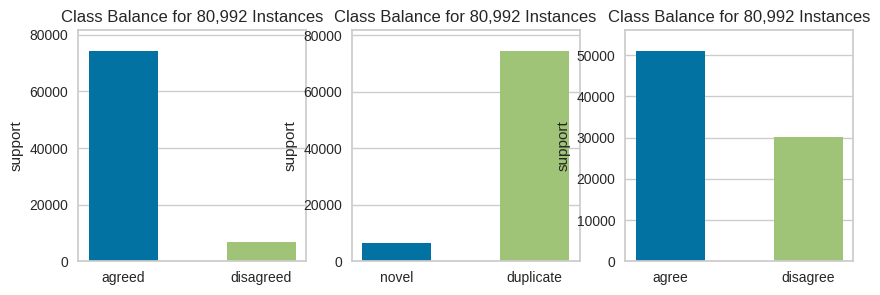

In [ ]:
#!pip install yellowbrick
from yellowbrick.target import ClassBalance
import matplotlib.pyplot as plt

print("Class balance for train data: ")
fig, ((ax1, ax2, ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(10,3))

classes = le.inverse_transform(np.arange(2))
classes2 = le2.inverse_transform(np.arange(2))

visualiser_bd = ClassBalance(labels=classes, ax=ax1)
visualiser_bd.fit(Y_bd)
visualiser_bd.finalize()

visualiser_nv = ClassBalance(labels=['novel', 'duplicate'], ax=ax2) # 0 = novel, 1 = duplicate
visualiser_nv.fit(Y_nv)
visualiser_nv.finalize()

visualiser_em = ClassBalance(labels=classes2, ax=ax3) # 0 = agree, 1 = disagree
visualiser_em.fit(Y_em)
visualiser_em.finalize()

In [ ]:
print("BD train data class balance: ")
unique, counts = np.unique(Y_bd, return_counts=True)
dict(zip(unique, counts))

BD train data class balance: 


{0: 74177, 1: 6815}

In [ ]:
# read test data
X1_test, X2_test, Y_nv_test, Y_em_test, Y_bd_test = get_data(tokenizer, MAX_LENGTH, test_df)

Loading data


Class distribution for test data: 


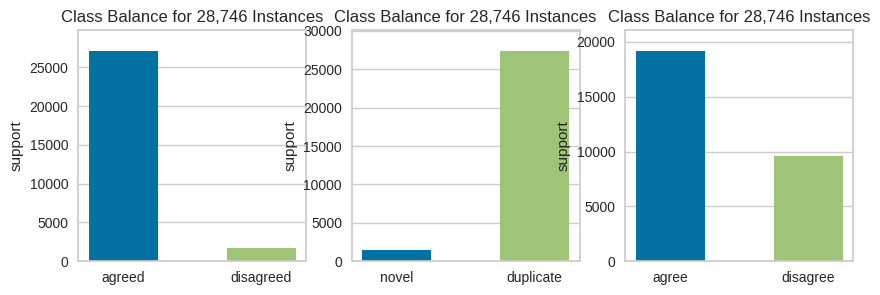

In [ ]:
print("Class distribution for test data: ")
fig, ((ax1, ax2, ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(10,3))
classes = le.inverse_transform(np.arange(2))
classes2 = le2.inverse_transform(np.arange(2))

visualiser_bd = ClassBalance(labels=classes, ax=ax1)
visualiser_bd.fit(Y_bd_test)
visualiser_bd.finalize()

visualiser_nv = ClassBalance(labels=['novel', 'duplicate'], ax=ax2)
visualiser_nv.fit(Y_nv_test)
visualiser_nv.finalize()

visualiser_em = ClassBalance(labels=classes2, ax=ax3)
visualiser_em.fit(Y_em_test)
visualiser_em.finalize()

In [ ]:
print("BD test data class balance: ")
unique, counts = np.unique(Y_bd_test, return_counts=True)
dict(zip(unique, counts))

BD test data class balance: 


{0: 27075, 1: 1671}

In [ ]:
# Creating one-hot encodings
y_train_nv = keras.utils.to_categorical(Y_nv)
# print(y_train_nv)
y_train_em = keras.utils.to_categorical(Y_em)
# print(y_train_em)
y_train_bd = keras.utils.to_categorical(Y_bd)
# print(y_train_bd)
y_test_nv = keras.utils.to_categorical(Y_nv_test)
# print(y_test_nv)
y_test_em = keras.utils.to_categorical(Y_em_test)
# print(y_test_em)
y_test_bd = keras.utils.to_categorical(Y_bd_test)
# print(y_test_bd)

In [ ]:
from sklearn.model_selection import train_test_split
VALIDATION_RATIO = 0.1
RANDOM_STATE = 9527
x1_train, x1_val, \
x2_train, x2_val, \
y_train_nv, y_val_nv, \
y_train_em, y_val_em, \
y_train_bd, y_val_bd = \
    train_test_split(
        X1, X2, 
        y_train_nv, y_train_em, 
        y_train_bd,
        test_size=VALIDATION_RATIO, 
        random_state=RANDOM_STATE
)

In [ ]:
print("Training Set")
print("-" * 10)
print(f"x1_train: {x1_train.shape}")
print(f"x2_train: {x2_train.shape}")
# print(f"x1_train_bert : {x1_train_bert.shape}")
# print(f"x2_train_bert : {x2_train_bert.shape}")

print("-" * 10)
print(f"x1_val:   {x1_val.shape}")
print(f"x2_val:   {x2_val.shape}")
# print(f"x1_val_bert:   {x1_val_bert.shape}")
# print(f"x2_val_bert :   {x2_val_bert.shape}")
print("-" * 10)
print("Test Set")

Training Set
----------
x1_train: (72892, 100)
x2_train: (72892, 100)
----------
x1_val:   (8100, 100)
x2_val:   (8100, 100)
----------
Test Set


In [ ]:
NUM_CLASSES = 2

MAX_SEQUENCE_LENGTH = MAX_LENGTH

MAX_NUM_WORDS = embedding_matrix.shape[0]

NUM_EMBEDDING_DIM = embedding_matrix.shape[1]

NUM_FILTERS = 64

In [ ]:
################# Disagreement detection using CNN ##################

pre_input = Input(
    shape=(MAX_SEQUENCE_LENGTH, ), 
    dtype='int32')
hyp_input = Input(
    shape=(MAX_SEQUENCE_LENGTH, ), 
    dtype='int32')

# Embedding layer
embedding_layer = Embedding(MAX_NUM_WORDS, NUM_EMBEDDING_DIM, weights = [embedding_matrix], trainable = True)
pre_embedded = embedding_layer(pre_input)
hyp_embedded = embedding_layer(hyp_input)

# Convolutional layers
conv_layer = Conv1D(NUM_FILTERS, 3, activation='relu', name='conv_0')
pre_conv_output = conv_layer(pre_embedded)
hyp_conv_output = conv_layer(hyp_embedded)

# Max Pooling layers
pre_pooled = GlobalMaxPooling1D()(pre_conv_output)
hyp_pooled = GlobalMaxPooling1D()(hyp_conv_output)

# Concatenating hidden representations of premise and hypothesis
comb_pre_hyp = concatenate([pre_pooled, hyp_pooled],axis=-1)

# Dense layer
dense_out = Dense(units=64, activation='tanh', name = 'dense_0')(comb_pre_hyp)

# Classification layer
predictions =  Dense(units=NUM_CLASSES, activation='softmax',name = 'dense_1')(dense_out)

model_cnn_dg = Model(
    inputs=[pre_input, hyp_input], 
    outputs=predictions)

model_cnn_dg.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 100, 300)     120000000   ['input_9[0][0]',                
                                                                  'input_10[0][0]']               
                                                                                                  
 conv_0 (Conv1D)                (None, 98, 64)       57664       ['embedding_4[0][0]',      

In [ ]:
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
lr = 0.001
opt = Adam(lr=lr, decay=lr/50)
model_cnn_dg.compile(
    optimizer = opt,
    loss = 'categorical_crossentropy',
    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='bd_cnn_disagreement.h5', verbose=1, save_best_only=True)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# CNN for disagreement detection
BATCH_SIZE = 256
NUM_EPOCHS = 50
stop = [EarlyStopping(monitor='val_loss', patience=0.001)]
history = model_cnn_dg.fit(x=[x1_train, x2_train],
                    y=y_train_bd,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=(
                      [x1_val, x2_val], 
                      y_val_bd
                    ),
                    shuffle=True,
                    callbacks=stop,
          )

Epoch 1/50
285/285 [==============================] - 32s 79ms/step - loss: 0.0939 - accuracy: 0.9702 - val_loss: 0.0462 - val_accuracy: 0.9868
Epoch 2/50
285/285 [==============================] - 22s 77ms/step - loss: 0.0223 - accuracy: 0.9933 - val_loss: 0.0356 - val_accuracy: 0.9894
Epoch 3/50
285/285 [==============================] - 22s 77ms/step - loss: 0.0050 - accuracy: 0.9988 - val_loss: 0.0357 - val_accuracy: 0.9907


In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
predictions = model_cnn_dg.predict(
    [X1_test, X2_test])

899/899 [==============================] - 2s 2ms/step


In [ ]:
# Result Labels
res_df = pd.DataFrame()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    
    # Loss
    fig, ((ax1, ax2)) = plt.subplots(ncols=2, nrows=1, figsize=(8,4))
    losses = ['loss','val_loss']
    i = 0
    for ax in [ax1, ax2]:
      ax.plot(history.history[losses[i]], 'g')
      ax.set_title(losses[i])
      ax.set_xlabel('epochs')
      ax.set_ylabel(losses[i])
      i += 1
   
    plt.show()

    # Accuracy
    fig, ((ax1, ax2)) = plt.subplots(ncols=2, nrows=1, figsize=(8,4))
    accuracies = ['accuracy','val_accuracy']
    i = 0
    for ax in [ax1, ax2]:
      ax.plot(history.history[accuracies[i]], 'b')
      ax.set_title(accuracies[i])
      ax.set_xlabel('epochs')
      ax.set_ylabel(accuracies[i])
      i += 1
   
    plt.show()

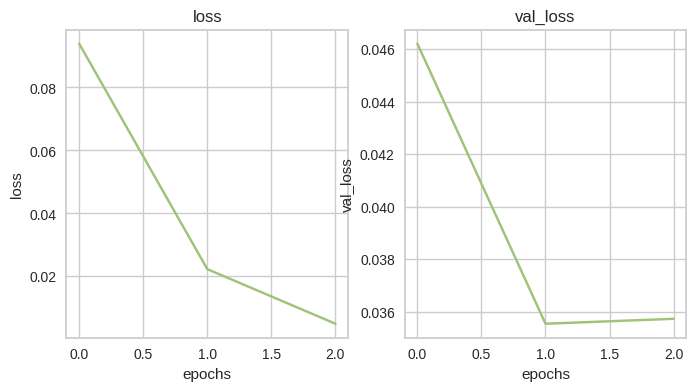

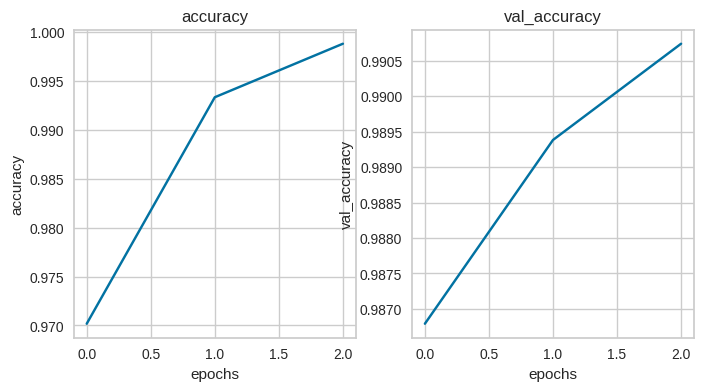

In [ ]:
#print(history.history['bd_loss'])
plot_history(history)

In [ ]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
y_pred = [idx for idx in np.argmax(predictions, axis=1)]
res_df['DG_Labels'] = y_pred
#print(y_pred)
print('BD Accuracy is')
print(metrics.accuracy_score(Y_bd_test, y_pred)*100)
print(classification_report(Y_bd_test, y_pred, target_names = ['agreed', 'disagreed']))

BD Accuracy is
97.70630766113526
              precision    recall  f1-score   support

      agreed       0.98      0.99      0.99 1805.000009024593
   disagreed       0.97      0.89      0.92 334.1999999999896

    accuracy                           0.98 2139.200009024583
   macro avg       0.97      0.94      0.95 2139.200009024583
weighted avg       0.98      0.98      0.98 2139.200009024583



[[26915   160]
 [  192  1479]]


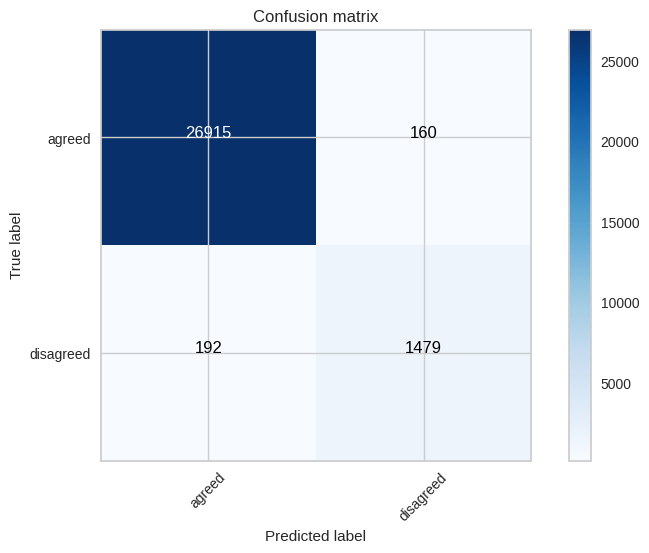

In [ ]:
cnf_matrix = confusion_matrix(Y_bd_test,y_pred)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,classes=le.inverse_transform(np.arange(2)))

In [ ]:
################# Emotion recognition using CNN ##################

pre_input_em = Input(
    shape=(MAX_SEQUENCE_LENGTH, ), 
    dtype='int32')
hyp_input_em = Input(
    shape=(MAX_SEQUENCE_LENGTH, ), 
    dtype='int32')

# Embedding layer
embedding_layer = Embedding(MAX_NUM_WORDS, NUM_EMBEDDING_DIM, weights = [embedding_matrix], trainable = True)
pre_embedded_em = embedding_layer(pre_input_em)
hyp_embedded_em = embedding_layer(hyp_input_em)

# Convolutional layers
conv_layer = Conv1D(NUM_FILTERS, 3, activation='relu', name='conv_em_0')
pre_conv_output_em = conv_layer(pre_embedded_em)
hyp_conv_output_em = conv_layer(hyp_embedded_em)

# Max Pooling layers
pre_pooled_em = GlobalMaxPooling1D()(pre_conv_output_em)
hyp_pooled_em = GlobalMaxPooling1D()(hyp_conv_output_em)

# Concatenating hidden representations of premise and hypothesis
comb_pre_hyp_em = concatenate([pre_pooled_em, hyp_pooled_em],axis=-1)

# Dense layer
dense_out_em = Dense(units=64, activation='tanh', name = 'dense_em_0')(comb_pre_hyp_em)

# Classification layer
predictions_em =  Dense(units=NUM_CLASSES, activation='softmax',name = 'dense_em_1')(dense_out_em)

model_cnn_em = Model(
    inputs=[pre_input_em, hyp_input_em], 
    outputs=predictions_em)

model_cnn_em.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 100, 300)     120000000   ['input_11[0][0]',               
                                                                  'input_12[0][0]']               
                                                                                                  
 conv_0 (Conv1D)                (None, 98, 64)       57664       ['embedding_5[0][0]',      

In [ ]:
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
lr = 0.001
opt = Adam(lr=lr, decay=lr/50)
model_cnn_em.compile(
    optimizer = opt,
    loss = 'categorical_crossentropy',
    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='bd_cnn_emotion.h5', verbose=1, save_best_only=True)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# CNN for emotion recognition
BATCH_SIZE = 256
NUM_EPOCHS = 50
stop = [EarlyStopping(monitor='val_loss', patience=0.001)]
history = model_cnn_em.fit(x=[x1_train, x2_train],
                    y=y_train_em,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=(
                      [x1_val, x2_val], 
                      y_val_em
                    ),
                    shuffle=True,
                    callbacks=stop,
          )

Epoch 1/50
285/285 [==============================] - 25s 79ms/step - loss: 0.6409 - accuracy: 0.6280 - val_loss: 0.6137 - val_accuracy: 0.6357
Epoch 2/50
285/285 [==============================] - 23s 80ms/step - loss: 0.5572 - accuracy: 0.6990 - val_loss: 0.6020 - val_accuracy: 0.6553
Epoch 3/50
285/285 [==============================] - 22s 78ms/step - loss: 0.4692 - accuracy: 0.7694 - val_loss: 0.6225 - val_accuracy: 0.6706


In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
predictions_em = model_cnn_em.predict(
    [X1_test, X2_test])

899/899 [==============================] - 3s 3ms/step


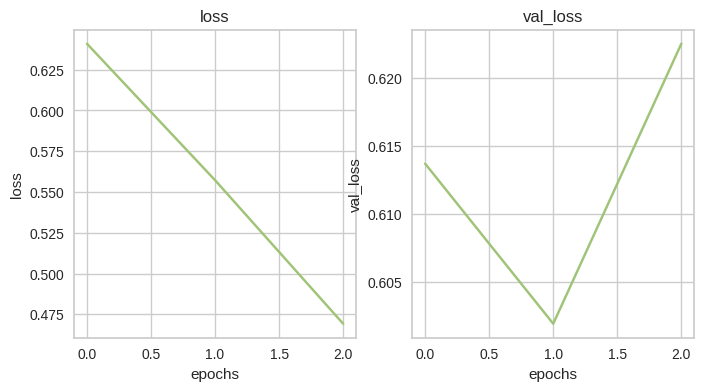

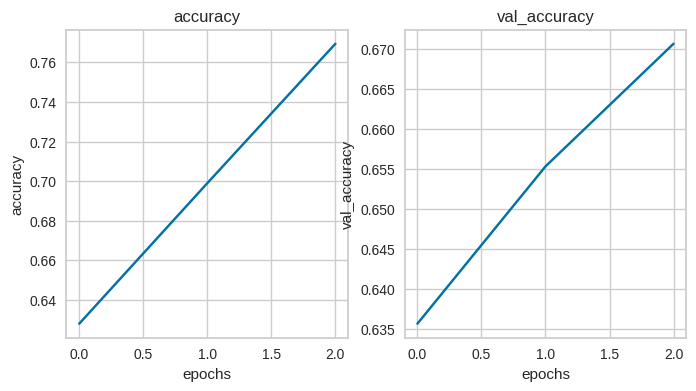

In [ ]:
plot_history(history)

In [ ]:
y_pred_em = [idx for idx in np.argmax(predictions_em, axis=1)]
res_df['EM_Labels'] = y_pred_em
print('Emotion Accuracy is')
print(metrics.accuracy_score(Y_em_test, y_pred_em)*100)
print(classification_report(Y_em_test, y_pred_em, target_names = ['agreed', 'disagreed']))

Emotion Accuracy is
62.29743206631716
              precision    recall  f1-score   support

      agreed       0.69      0.76      0.73 1407.0666727150565
   disagreed       0.44      0.36      0.39 732.1333363101002

    accuracy                           0.62 2139.2000090251568
   macro avg       0.57      0.56      0.56 2139.2000090251568
weighted avg       0.61      0.62      0.61 2139.2000090251568



[[14768  4364]
 [ 6282  3332]]


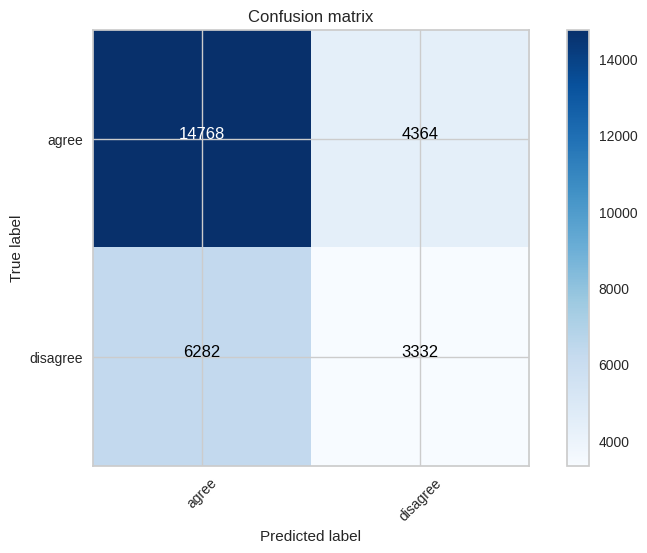

In [ ]:
cnf_matrix = confusion_matrix(Y_em_test,y_pred_em)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,classes=le2.inverse_transform(np.arange(2)))

In [ ]:
# Saving the labels
res_df.to_csv("baselines/outputs/BD_Baseline_CNN_results.csv", index = False)